In [5]:
import pandas as pd

# Load your data
nba_df = pd.read_csv("nba_6teams_2015-2024_complete.csv")

def process_nba_data(df):
    """
    Filter NBA data to top 7 players by minutes played per game
    and calculate their contribution to team score.
    """
    
    # Columns to keep
    id_cols = ['game_id', 'team_type', 'season', 'team_scraped']
    stat_cols = ['MP_basic', 'PTS', 'FG%', 'ORtg', 'DRtg', 'TS%', 'GmSc', '+/-', 'AST%']
    
    all_cols = id_cols + stat_cols
    
    # Filter to only needed columns
    df_filtered = df[all_cols].copy()
    
    # Convert numeric columns from string to float
    numeric_cols = ['PTS', 'FG%', 'ORtg', 'DRtg', 'TS%', 'GmSc', '+/-', 'AST%']
    for col in numeric_cols:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')
    
    # Convert MP_basic to numeric (handles "MM:SS" format if needed)
    def convert_minutes(x):
        try:
            if pd.isna(x):
                return 0.0
            if isinstance(x, str):
                if ':' in x:
                    parts = x.split(':')
                    return float(parts[0]) + float(parts[1])/60
                else:
                    # Handle "Did Not Dress", "Did Not Play", etc.
                    return 0.0
            return float(x)
        except:
            return 0.0
    
    df_filtered['MP_numeric'] = df_filtered['MP_basic'].apply(convert_minutes)
    
    # Remove players with 0 minutes (Did Not Dress, Did Not Play, etc.)
    df_filtered = df_filtered[df_filtered['MP_numeric'] > 0].copy()
    
    # Group by game and team, then get top 7 by minutes played
    def get_top7_with_contribution(group):
        # Sort by minutes played and get top 7
        top7 = group.nlargest(7, 'MP_numeric')
        
        # Calculate total team score for this game
        team_total_pts = group['PTS'].sum()
        
        # Calculate contribution percentage for top 7 players
        top7['pts_contribution_%'] = (top7['PTS'] / team_total_pts * 100).round(2)
        top7['pts_contribution_number'] = top7['PTS']
        
        return top7
    
    # Apply grouping
    result = df_filtered.groupby(['game_id', 'team_scraped'], group_keys=False).apply(
        get_top7_with_contribution
    ).reset_index(drop=True)
    
    # Reorder columns for better readability
    final_cols = (id_cols + ['MP_basic', 'MP_numeric', 'PTS', 'pts_contribution_%', 
                             'pts_contribution_number', 'FG%', 'TS%', 'ORtg', 'DRtg', 
                             'GmSc', '+/-', 'AST%'])
    
    result = result[final_cols]
    
    return result

# Example usage:
processed_data = process_nba_data(nba_df)

# Display first few rows
print("First 10 rows of processed data:")
print(processed_data.head(10))

print("\n" + "="*80 + "\n")

# Show summary: total contribution % by game/team (should be close to 100%)
print("Sample of top 7 players' total scoring contribution by game:")
contribution_summary = processed_data.groupby(['game_id', 'team_scraped'])['pts_contribution_%'].sum().head(10)
print(contribution_summary)

print("\n" + "="*80 + "\n")

# Show dataset shape
print(f"Total rows in filtered dataset: {len(processed_data)}")
print(f"Unique games: {processed_data['game_id'].nunique()}")
print(f"Unique teams: {processed_data['team_scraped'].nunique()}")

# Save to CSV
processed_data.to_csv('nba_top7_filtered.csv', index=False)
print("\nData saved to 'nba_top7_filtered.csv'")

C:\Users\khush\AppData\Local\Temp\ipykernel_10756\3849963459.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df_filtered.groupby(['game_id', 'team_scraped'], group_keys=False).apply(


First 10 rows of processed data:
        game_id team_type  season team_scraped MP_basic  MP_numeric   PTS  \
0  201410280LAL      away    2015          LAL    30:55   30.916667   9.0   
1  201410280LAL      away    2015          LAL    30:46   30.766667  32.0   
2  201410280LAL      away    2015          LAL    30:31   30.516667  16.0   
3  201410280LAL      away    2015          LAL    29:34   29.566667  16.0   
4  201410280LAL      home    2015          LAL    29:08   29.133333   7.0   
5  201410280LAL      home    2015          LAL    29:00   29.000000  19.0   
6  201410280LAL      home    2015          LAL    27:35   27.583333  17.0   
7  201410290BOS      away    2015          BOS    39:03   39.050000  19.0   
8  201410290BOS      home    2015          BOS    35:38   35.633333  17.0   
9  201410290BOS      away    2015          BOS    34:27   34.450000  19.0   

   pts_contribution_%  pts_contribution_number    FG%    TS%   ORtg   DRtg  \
0                4.55                    

 pts_contribution_%: Calculate each top 7 player's contribution - Divide their individual points by the team total and multiply by 100


 The team_total_pts includes ALL players (bench too), not just top 7. That's why when you sum the contribution percentages for the top 7 players, you get 50-68% - the remaining percentage represents points scored by players outside the top 7 (bench players, players with fewer minutes, etc.).

STEP 1: CREATE WIN/LOSS TARGET VARIABLE

Team-game level data created: 9538 rows
Unique games: 4769
Unique teams: 6


C:\Users\khush\AppData\Local\Temp\ipykernel_10756\1609643442.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_game_stats = team_game_stats.groupby('game_id', group_keys=False).apply(determine_winner)



Wins created! Distribution:
win
1.0    4769
0.0    4769
Name: count, dtype: int64
Win rate: 50.00%

STEP 2: ENCODE HOME/AWAY AND PREPARE FOR TRAVEL DATA
✅ Home/Away encoded:
   Home games: 4769
   Away games: 4769

💡 NOTE: Travel features will be added later when your teammate provides data
   For now, we'll build a strong baseline using home/away + performance stats

STEP 3: BASELINE REGRESSION MODEL

BASELINE MODEL PERFORMANCE:
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83       954
         1.0       0.83      0.84      0.84       954

    accuracy                           0.83      1908
   macro avg       0.83      0.83      0.83      1908
weighted avg       0.83      0.83      0.83      1908


ROC-AUC Score: 0.9174

FEATURE IMPORTANCE (Baseline Model):
              feature  coefficient
             avg_drtg    -3.001900
       top7_total_pts     2.519448
             avg_ortg     2.277186
top7_contribution_pct    -1.974719
  

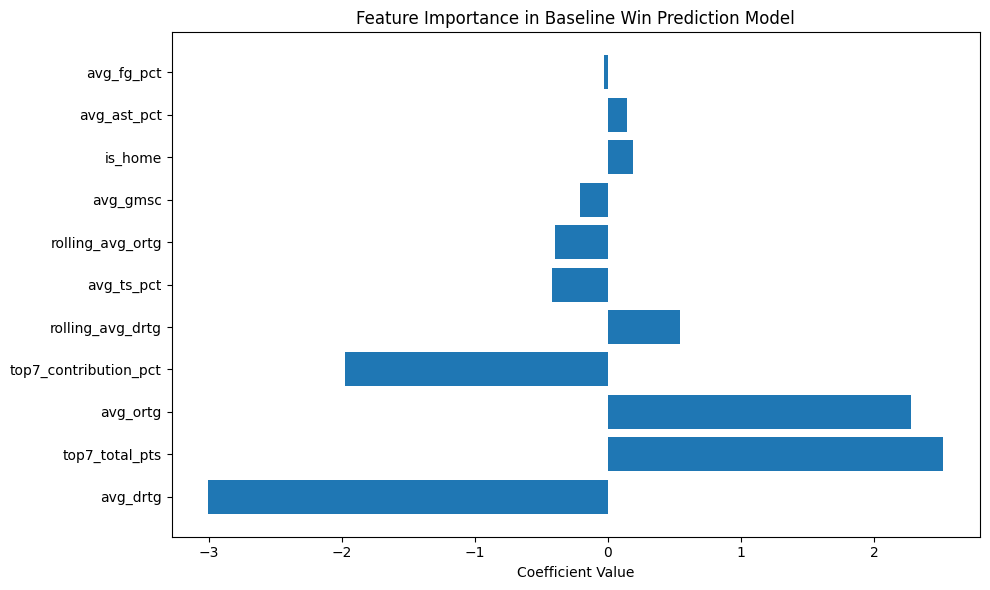

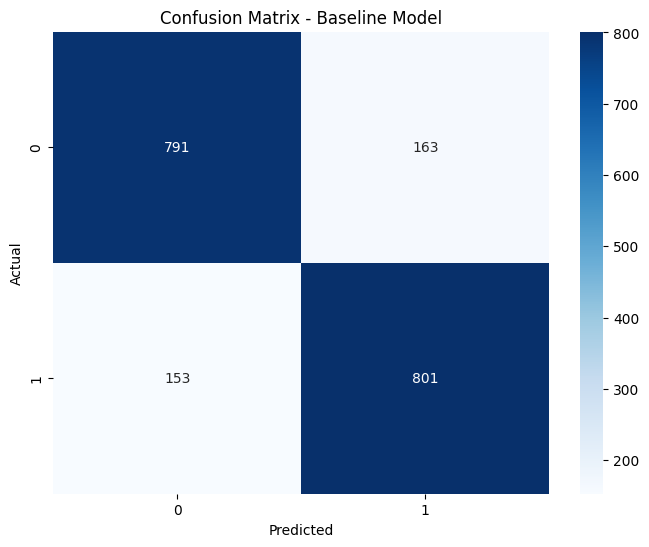

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
processed_data = pd.read_csv('nba_top7_filtered.csv')

print("="*80)
print("STEP 1: CREATE WIN/LOSS TARGET VARIABLE")
print("="*80)

# Aggregate top 7 players' stats to team-level per game
team_game_stats = processed_data.groupby(['game_id', 'team_scraped', 'team_type', 'season']).agg({
    'PTS': 'sum',  # Total points from top 7
    'pts_contribution_%': 'sum',  # Total contribution % from top 7
    'FG%': 'mean',  # Average FG% of top 7
    'TS%': 'mean',  # Average TS% of top 7
    'ORtg': 'mean',  # Average offensive rating
    'DRtg': 'mean',  # Average defensive rating
    'GmSc': 'mean',  # Average game score
    '+/-': 'sum',  # Total +/- (sum makes sense here)
    'AST%': 'mean',  # Average assist %
    'MP_numeric': 'sum'  # Total minutes from top 7
}).reset_index()

# Rename columns for clarity
team_game_stats.columns = ['game_id', 'team', 'team_type', 'season', 
                            'top7_total_pts', 'top7_contribution_pct', 
                            'avg_fg_pct', 'avg_ts_pct', 'avg_ortg', 'avg_drtg',
                            'avg_gmsc', 'total_plus_minus', 'avg_ast_pct', 'top7_total_mins']

print(f"\nTeam-game level data created: {len(team_game_stats)} rows")
print(f"Unique games: {team_game_stats['game_id'].nunique()}")
print(f"Unique teams: {team_game_stats['team'].nunique()}")

# Create win/loss variable
# Method: For each game, compare teams' +/- to determine winner
def determine_winner(game_df):
    """Determine winner based on +/- score"""
    if len(game_df) != 2:
        return game_df  # Skip games with data issues
    
    team1, team2 = game_df.iloc[0], game_df.iloc[1]
    
    # Team with positive +/- wins (or higher +/-)
    if team1['total_plus_minus'] > team2['total_plus_minus']:
        game_df.loc[game_df.index[0], 'win'] = 1
        game_df.loc[game_df.index[1], 'win'] = 0
    else:
        game_df.loc[game_df.index[0], 'win'] = 0
        game_df.loc[game_df.index[1], 'win'] = 1
    
    return game_df

# Apply winner determination
team_game_stats['win'] = None
team_game_stats = team_game_stats.groupby('game_id', group_keys=False).apply(determine_winner)
team_game_stats['win'] = team_game_stats['win'].astype(float)

print(f"\nWins created! Distribution:")
print(team_game_stats['win'].value_counts())
print(f"Win rate: {team_game_stats['win'].mean():.2%}")

# Sort by date (game_id contains date info)
team_game_stats = team_game_stats.sort_values(['team', 'game_id']).reset_index(drop=True)

print("\n" + "="*80)
print("STEP 2: ENCODE HOME/AWAY AND PREPARE FOR TRAVEL DATA")
print("="*80)

# Encode home/away (this is important for win probability!)
team_game_stats['is_home'] = (team_game_stats['team_type'] == 'home').astype(int)

print(f"✅ Home/Away encoded:")
print(f"   Home games: {team_game_stats['is_home'].sum()}")
print(f"   Away games: {(team_game_stats['is_home']==0).sum()}")

# OPTIONAL: Create placeholder columns for travel data (your teammate will provide this later)
# Uncomment these when you're ready to add travel data:
# team_game_stats['cumulative_miles'] = 0  
# team_game_stats['rest_days'] = 3  
# team_game_stats['games_in_last_7days'] = 2  

print("\n💡 NOTE: Travel features will be added later when your teammate provides data")
print("   For now, we'll build a strong baseline using home/away + performance stats")

print("\n" + "="*80)
print("STEP 3: BASELINE REGRESSION MODEL")
print("="*80)

# Feature engineering: create rolling averages for recent performance
team_game_stats['rolling_avg_ortg'] = team_game_stats.groupby('team')['avg_ortg'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)
team_game_stats['rolling_avg_drtg'] = team_game_stats.groupby('team')['avg_drtg'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

# Prepare features for modeling
feature_cols = [
    'is_home',  # Home court advantage!
    'top7_total_pts', 'top7_contribution_pct', 'avg_fg_pct', 'avg_ts_pct',
    'avg_ortg', 'avg_drtg', 'avg_gmsc', 'avg_ast_pct',
    'rolling_avg_ortg', 'rolling_avg_drtg'
    # Travel features will be added here when available:
    # 'cumulative_miles', 'rest_days', 'games_in_last_7days'
]

# Remove rows with NaN
model_data = team_game_stats[feature_cols + ['win']].dropna()

X = model_data[feature_cols]
y = model_data['win']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline logistic regression
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = baseline_model.predict(X_test_scaled)
y_pred_proba = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nBASELINE MODEL PERFORMANCE:")
print(classification_report(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE (Baseline Model):")
print("="*80)
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Baseline Win Prediction Model')
plt.tight_layout()
plt.savefig('baseline_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n Feature importance plot saved: baseline_feature_importance.png")

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
print(" Confusion matrix saved: baseline_confusion_matrix.png")

print("\n" + "="*80)
print("STEP 4: SAVE PROCESSED DATA FOR TCN MODEL")
print("="*80)

# Save the processed data with win labels
team_game_stats.to_csv('nba_team_game_with_win.csv', index=False)
print("✅ Saved: nba_team_game_with_win.csv")
print(f"   Shape: {team_game_stats.shape}")
print(f"   Columns: {list(team_game_stats.columns)}")

print("\n" + "="*80)

print("\n Current model uses home/away advantage - already provides insights!")
print("   Once travel data arrives, we'll add it and test your hypothesis.")
print("="*80)

MULTICOLLINEARITY DETECTION & REMOVAL (FROM SCRATCH)

Dataset: 9538 samples, 11 features
Features: ['is_home', 'top7_total_pts', 'top7_contribution_pct', 'avg_fg_pct', 'avg_ts_pct', 'avg_ortg', 'avg_drtg', 'avg_gmsc', 'avg_ast_pct', 'rolling_avg_ortg', 'rolling_avg_drtg']

STEP 1: COMPUTING CORRELATION MATRIX 

✅ Correlation Matrix Computed!

Correlation Matrix (rounded to 2 decimals):
                       is_home  top7_total_pts  top7_contribution_pct  \
is_home                   1.00            0.04                   0.04   
top7_total_pts            0.04            1.00                   0.94   
top7_contribution_pct     0.04            0.94                   1.00   
avg_fg_pct                0.04            0.36                   0.28   
avg_ts_pct                0.05            0.39                   0.29   
avg_ortg                  0.08            0.42                   0.30   
avg_drtg                 -0.11            0.08                  -0.13   
avg_gmsc                  0

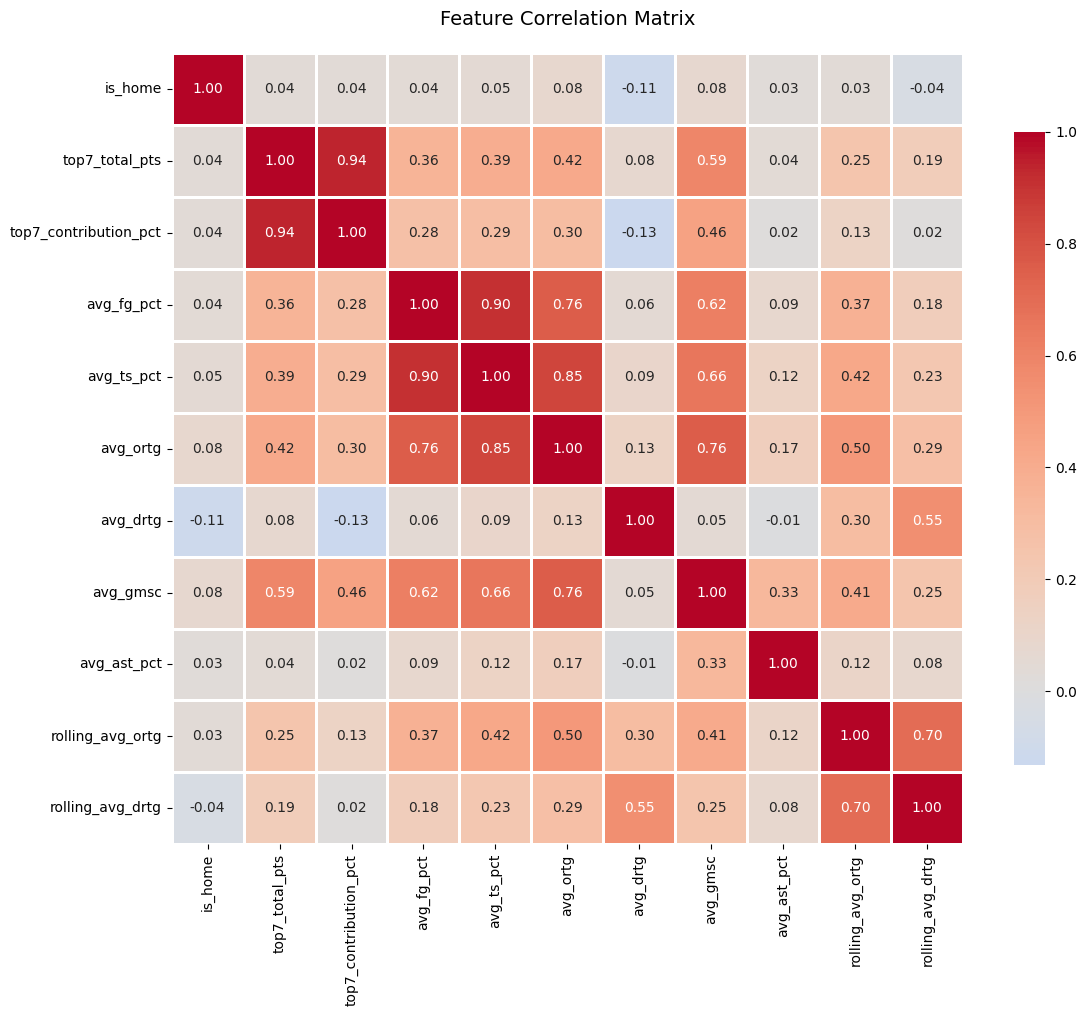

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
team_game_stats = pd.read_csv('nba_team_game_with_win.csv')

print("="*80)
print("MULTICOLLINEARITY DETECTION & REMOVAL (FROM SCRATCH)")
print("="*80)

# Original features
feature_cols = [
    'is_home',
    'top7_total_pts', 'top7_contribution_pct', 'avg_fg_pct', 'avg_ts_pct',
    'avg_ortg', 'avg_drtg', 'avg_gmsc', 'avg_ast_pct',
    'rolling_avg_ortg', 'rolling_avg_drtg'
]

# Prepare data
data = team_game_stats[feature_cols].dropna()
n_samples, n_features = data.shape

print(f"\nDataset: {n_samples} samples, {n_features} features")
print(f"Features: {feature_cols}")

# ============================================================================
# STEP 1: CALCULATE CORRELATION MATRIX 
# ============================================================================
print("\n" + "="*80)
print("STEP 1: COMPUTING CORRELATION MATRIX ")
print("="*80)

def calculate_mean(x):
    """Calculate mean of array"""
    return np.sum(x) / len(x)

def calculate_std(x):
    """Calculate standard deviation"""
    mean = calculate_mean(x)
    variance = np.sum((x - mean) ** 2) / len(x)
    return np.sqrt(variance)

def calculate_correlation(x, y):
    """
    Calculate Pearson correlation coefficient between two variables
    Formula: r = Σ[(xi - x̄)(yi - ȳ)] / √[Σ(xi - x̄)² * Σ(yi - ȳ)²]
    """
    n = len(x)
    
    # Calculate means
    mean_x = calculate_mean(x)
    mean_y = calculate_mean(y)
    
    # Calculate deviations from mean
    dev_x = x - mean_x
    dev_y = y - mean_y
    
    # Calculate correlation
    numerator = np.sum(dev_x * dev_y)
    denominator = np.sqrt(np.sum(dev_x ** 2) * np.sum(dev_y ** 2))
    
    if denominator == 0:
        return 0
    
    return numerator / denominator

# Build correlation matrix manually
n_features = len(feature_cols)
correlation_matrix = np.zeros((n_features, n_features))

for i in range(n_features):
    for j in range(n_features):
        x = data[feature_cols[i]].values
        y = data[feature_cols[j]].values
        correlation_matrix[i, j] = calculate_correlation(x, y)

# Convert to DataFrame for readability
corr_df = pd.DataFrame(
    correlation_matrix,
    index=feature_cols,
    columns=feature_cols
)

print("\n✅ Correlation Matrix Computed!")
print("\nCorrelation Matrix (rounded to 2 decimals):")
print(corr_df.round(2))

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("\n📊 Correlation matrix visualization saved: correlation_matrix.png")

# ============================================================================
# STEP 2: DETECT MULTICOLLINEARITY 
# ============================================================================
print("\n" + "="*80)
print("STEP 2: VARIANCE INFLATION FACTOR (VIF) ")
print("="*80)
print("\nVIF measures how much variance is inflated due to multicollinearity")
print("Formula: VIF = 1 / (1 - R²)")
print("  - VIF = 1: No correlation")
print("  - VIF > 5: Moderate multicollinearity")
print("  - VIF > 10: High multicollinearity (REMOVE)")

def calculate_r_squared(X, y):
    """
    Calculate R² for linear regression
    R² = 1 - (SS_res / SS_tot)
    """
    n = len(y)
    
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X])
    
    # Calculate coefficients using Normal Equation: β = (X'X)^(-1)X'y
    try:
        XtX = X_with_intercept.T @ X_with_intercept
        Xty = X_with_intercept.T @ y
        beta = np.linalg.solve(XtX, Xty)
    except:
        # If singular matrix, use pseudoinverse
        beta = np.linalg.pinv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
    
    # Predictions
    y_pred = X_with_intercept @ beta
    
    # Calculate R²
    y_mean = calculate_mean(y)
    ss_tot = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared

def calculate_vif(data, feature_idx, feature_cols):
    """
    Calculate VIF for a specific feature
    VIF_i = 1 / (1 - R²_i)
    where R²_i is obtained by regressing feature i on all other features
    """
    # Get all features except the current one
    other_indices = [i for i in range(len(feature_cols)) if i != feature_idx]
    
    X = data[:, other_indices]  # Other features
    y = data[:, feature_idx]     # Target feature
    
    # Calculate R²
    r_squared = calculate_r_squared(X, y)
    
    # Calculate VIF
    if r_squared >= 0.9999:  # Almost perfect multicollinearity
        return float('inf')
    
    vif = 1 / (1 - r_squared)
    
    return vif

# Convert to numpy array for calculations
data_array = data.values

# Calculate VIF for each feature
vif_results = []
for i, feature in enumerate(feature_cols):
    vif = calculate_vif(data_array, i, feature_cols)
    vif_results.append({
        'Feature': feature,
        'VIF': vif
    })

vif_df = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)

print("\n" + "-"*60)
print("VIF Results:")
print("-"*60)
print(vif_df.to_string(index=False))
print("-"*60)

# ============================================================================
# STEP 3: IDENTIFY HIGHLY CORRELATED PAIRS
# ============================================================================
print("\n" + "="*80)
print("STEP 3: IDENTIFY HIGHLY CORRELATED FEATURE PAIRS")
print("="*80)

threshold = 0.8  # Correlation threshold

high_corr_pairs = []
for i in range(n_features):
    for j in range(i+1, n_features):
        corr_value = correlation_matrix[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append({
                'Feature 1': feature_cols[i],
                'Feature 2': feature_cols[j],
                'Correlation': corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                              key=abs, 
                                                              ascending=False)
    print(f"\n⚠️  Found {len(high_corr_pairs)} pairs with |correlation| > {threshold}:")
    print(high_corr_df.to_string(index=False))
else:
    print(f"\n✅ No feature pairs with |correlation| > {threshold}")

# ============================================================================
# STEP 4: FEATURE SELECTION STRATEGY
# ============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE SELECTION STRATEGY")
print("="*80)

features_to_remove = []

print("\n📋 REMOVAL DECISIONS:")
print("-"*60)

# Rule 1: Remove features with VIF > 10
for _, row in vif_df.iterrows():
    if row['VIF'] > 10:
        print(f"❌ {row['Feature']}: VIF = {row['VIF']:.2f} (HIGH - Remove)")
        features_to_remove.append(row['Feature'])
    elif row['VIF'] > 5:
        print(f"⚠️  {row['Feature']}: VIF = {row['VIF']:.2f} (Moderate - Monitor)")
    else:
        print(f"✅ {row['Feature']}: VIF = {row['VIF']:.2f} (Low - Keep)")

# Rule 2: From highly correlated pairs, remove the one with higher VIF
if high_corr_pairs:
    print("\n" + "-"*60)
    print("HIGHLY CORRELATED PAIRS - Keep feature with lower VIF:")
    print("-"*60)
    
    for pair in high_corr_pairs:
        feat1 = pair['Feature 1']
        feat2 = pair['Feature 2']
        
        vif1 = vif_df[vif_df['Feature'] == feat1]['VIF'].values[0]
        vif2 = vif_df[vif_df['Feature'] == feat2]['VIF'].values[0]
        
        if vif1 > vif2:
            remove = feat1
            keep = feat2
        else:
            remove = feat2
            keep = feat1
        
        print(f"  {feat1} (VIF={vif1:.2f}) vs {feat2} (VIF={vif2:.2f})")
        print(f"  → Remove: {remove}, Keep: {keep}")
        
        if remove not in features_to_remove:
            features_to_remove.append(remove)

# Final feature list
features_to_remove = list(set(features_to_remove))
final_features = [f for f in feature_cols if f not in features_to_remove]

print("\n" + "="*80)
print("FINAL FEATURE SELECTION")
print("="*80)
print(f"\n❌ Features to REMOVE ({len(features_to_remove)}):")
for feat in features_to_remove:
    print(f"   - {feat}")

print(f"\n✅ Features to KEEP ({len(final_features)}):")
for feat in final_features:
    print(f"   - {feat}")

# ============================================================================
# STEP 5: SAVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save correlation matrix
corr_df.to_csv('correlation_matrix.csv')
print("✅ Saved: correlation_matrix.csv")

# Save VIF results
vif_df.to_csv('vif_results.csv', index=False)
print("✅ Saved: vif_results.csv")

# Save final feature list
with open('selected_features.txt', 'w') as f:
    f.write("SELECTED FEATURES (After Multicollinearity Removal)\n")
    f.write("="*60 + "\n\n")
    for feat in final_features:
        f.write(f"{feat}\n")
print("✅ Saved: selected_features.txt")

# Save cleaned data with selected features
cleaned_data = team_game_stats[final_features + ['win']].dropna()
cleaned_data.to_csv('nba_cleaned_features.csv', index=False)
print("✅ Saved: nba_cleaned_features.csv")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Original features: {len(feature_cols)}")
print(f"Features removed: {len(features_to_remove)}")
print(f"Final features: {len(final_features)}")
print(f"Reduction: {len(features_to_remove)/len(feature_cols)*100:.1f}%")
print("\n🎯 Use these {len(final_features)} features for your models!")
print("="*80)

LINEAR REGRESSION MODEL - POINT DIFFERENTIAL PREDICTION

Note: Logistic regression was used initially to explore binary win/loss
Based on those insights, we now build Linear Regression for continuous
prediction of point differential (margin of victory/defeat)

STEP 1: CREATE TARGET VARIABLE - POINT DIFFERENTIAL
Target variable created: point_differential
Range: [-205.0, 171.0]
Mean: 5.91
Std: 41.31

Dataset size: 9538 observations
Features: 8
Training set: 7630 samples
Test set: 1908 samples

STEP 2: TRAIN MULTIPLE LINEAR REGRESSION MODELS

Training Linear Regression...
  Train R²: 0.6524 | Test R²: 0.6416
  Train RMSE: 24.45 | Test RMSE: 24.36
  CV R² (5-fold): 0.6506 (+/- 0.0137)

Training Ridge (alpha=1.0)...
  Train R²: 0.6524 | Test R²: 0.6416
  Train RMSE: 24.45 | Test RMSE: 24.36
  CV R² (5-fold): 0.6506 (+/- 0.0137)

Training Ridge (alpha=10.0)...
  Train R²: 0.6524 | Test R²: 0.6417
  Train RMSE: 24.45 | Test RMSE: 24.36
  CV R² (5-fold): 0.6506 (+/- 0.0136)

Training Lasso (a

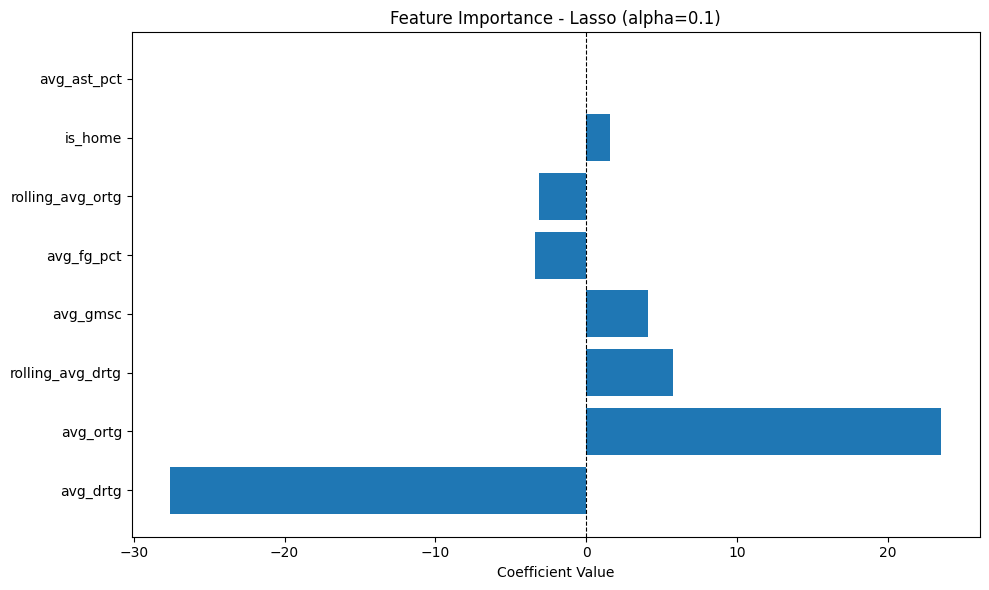

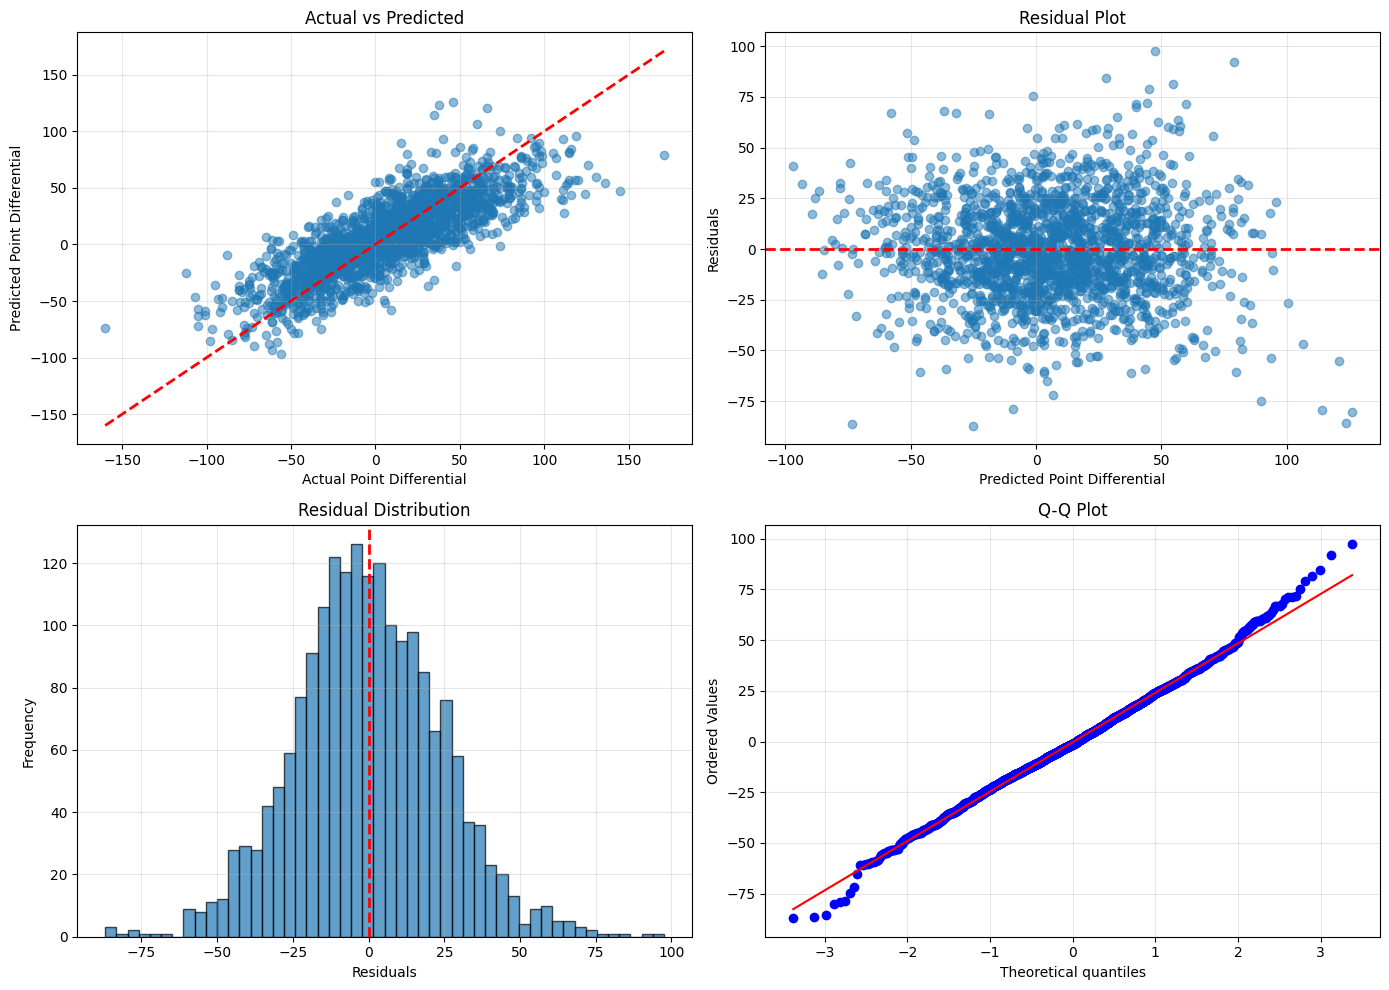

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("LINEAR REGRESSION MODEL - POINT DIFFERENTIAL PREDICTION")
print("="*80)
print("\nNote: Logistic regression was used initially to explore binary win/loss")
print("Based on those insights, we now build Linear Regression for continuous")
print("prediction of point differential (margin of victory/defeat)")
print("="*80)

# Load cleaned data
team_game_stats = pd.read_csv('nba_team_game_with_win.csv')

# Selected features from multicollinearity analysis
selected_features = [
    'is_home',
    'avg_fg_pct',
    'avg_ortg',
    'avg_drtg',
    'avg_gmsc',
    'avg_ast_pct',
    'rolling_avg_ortg',
    'rolling_avg_drtg'
]

print("\n" + "="*80)
print("STEP 1: CREATE TARGET VARIABLE - POINT DIFFERENTIAL")
print("="*80)

# Create point differential as target (continuous variable)
# Point differential = team's +/- score
team_game_stats['point_differential'] = team_game_stats['total_plus_minus']

print(f"Target variable created: point_differential")
print(f"Range: [{team_game_stats['point_differential'].min():.1f}, {team_game_stats['point_differential'].max():.1f}]")
print(f"Mean: {team_game_stats['point_differential'].mean():.2f}")
print(f"Std: {team_game_stats['point_differential'].std():.2f}")

# Prepare data
model_data = team_game_stats[selected_features + ['point_differential']].dropna()

X = model_data[selected_features]
y = model_data['point_differential']

print(f"\nDataset size: {len(X)} observations")
print(f"Features: {len(selected_features)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*80)
print("STEP 2: TRAIN MULTIPLE LINEAR REGRESSION MODELS")
print("="*80)

# Dictionary to store models and results
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=42, solver='svd'),
    'Ridge (alpha=10.0)': Ridge(alpha=10.0, random_state=42, solver='svd'),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1, random_state=42, max_iter=2000),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Evaluate
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                 scoring='r2')
    
    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std()
    })
    
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")
    print(f"  CV R² (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R²', ascending=False)
print("\n" + results_df.to_string(index=False))

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to: model_comparison_results.csv")

print("\n" + "="*80)
print("STEP 3: ANALYZE BEST MODEL")
print("="*80)

# Select best model (highest test R²)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {results_df.iloc[0]['Test R²']:.4f}")
print(f"Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} points")
print(f"Test MAE: {results_df.iloc[0]['Test MAE']:.2f} points")

# Feature importance (for Linear, Ridge, Lasso)
if hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': best_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\n" + "-"*60)
    print("FEATURE IMPORTANCE (Coefficients)")
    print("-"*60)
    print(feature_importance.to_string(index=False))
    
    # Visualize coefficients
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    print("\nFeature importance plot saved: feature_coefficients.png")

elif hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "-"*60)
    print("FEATURE IMPORTANCE")
    print("-"*60)
    print(feature_importance.to_string(index=False))
    
    # Visualize importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("\nFeature importance plot saved: feature_importance.png")

print("\n" + "="*80)
print("STEP 4: MODEL DIAGNOSTICS")
print("="*80)

# Get predictions from best model
y_pred = best_model.predict(X_test_scaled)

# Residual analysis
residuals = y_test - y_pred

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.4f} (should be close to 0)")
print(f"  Std: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[0, 0].set_xlabel('Actual Point Differential')
axes[0, 0].set_ylabel('Predicted Point Differential')
axes[0, 0].set_title('Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Point Differential')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residual Distribution')
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_diagnostics.png', dpi=300, bbox_inches='tight')
print("\nDiagnostic plots saved: model_diagnostics.png")

print("\n" + "="*80)
print("STEP 5: MODEL INTERPRETATION")
print("="*80)

print("\nKey Insights:")
print("-"*60)

if hasattr(best_model, 'coef_'):
    # Interpret coefficients
    coef_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': best_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\nTop 3 Positive Influences (increase point differential):")
    for i in range(min(3, len(coef_df))):
        row = coef_df.iloc[i]
        if row['Coefficient'] > 0:
            print(f"  {i+1}. {row['Feature']}: +{row['Coefficient']:.3f}")
    
    print("\nTop 3 Negative Influences (decrease point differential):")
    negative_df = coef_df[coef_df['Coefficient'] < 0].head(3)
    for i, (_, row) in enumerate(negative_df.iterrows()):
        print(f"  {i+1}. {row['Feature']}: {row['Coefficient']:.3f}")

print("\n" + "="*80)
print("STEP 6: SAVE FINAL MODEL")
print("="*80)

import pickle

# Save best model and scaler
with open('best_linear_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model saved: best_linear_model.pkl")
print("Scaler saved: feature_scaler.pkl")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'residual': residuals.values
})
predictions_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved: model_predictions.csv")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print(f"Performance:")
print(f"  - R² Score: {results_df.iloc[0]['Test R²']:.4f}")
print(f"  - RMSE: {results_df.iloc[0]['Test RMSE']:.2f} points")
print(f"  - MAE: {results_df.iloc[0]['Test MAE']:.2f} points")
print(f"\nInterpretation:")
print(f"  - Model explains {results_df.iloc[0]['Test R²']*100:.1f}% of variance in point differential")
print(f"  - Average prediction error: {results_df.iloc[0]['Test MAE']:.1f} points")
print(f"\nModel is ready for:")
print("  1. Integration with travel data")
print("  2. Replication on Baseball dataset")
print("  3. Temporal model comparison")
print("="*80)